# Lotka–Volterra ODE Model (pretty much taken from NumPyro)



**Model equations:**
- $\frac{du}{dt} = (\alpha - \beta v) \cdot u$ (prey dynamics)
- $\frac{dv}{dt} = (-\gamma + \delta u) \cdot v$ (predator dynamics)




In [100]:
# Uncomment if you don't have the packages installed

# using Pkg
# Pkg.add(["Gen", "DifferentialEquations", "Distributions"])

In [101]:
# Load required packages
using Gen
using DifferentialEquations
using Distributions
using Random
using Statistics
using LinearAlgebra, Statistics, Random


## Lotka-Volterra Differential Equation

In [102]:

function lotka_volterra_ode!(dz, z, theta, t)
    u, v = z              
    α, β, γ, δ = theta    
    
    dz[1] = (α - β * v) * u      
    dz[2] = (-γ + δ * u) * v     
end

lotka_volterra_ode! (generic function with 1 method)

##  ODE (Ordinary Differential EquaTion) solver



In [103]:

function solve_lv(theta, z_init, ts)
    tspan = (minimum(ts), maximum(ts))
    
    # solve the ODE using some solver
    prob = ODEProblem(lotka_volterra_ode!, z_init, tspan, theta)
    sol = solve(prob, Tsit5(), saveat=ts, abstol=1e-8, reltol=1e-8)

    # Convert solution to T×2 array, where T - time steps and we have 1 T array for each species
    T = length(ts)
    z_true = zeros(T, 2)
    for i in 1:T
        z_true[i, 1] = sol.u[i][1]  # prey
        z_true[i, 2] = sol.u[i][2]  # predator
    end
    
    return z_true
end

solve_lv (generic function with 1 method)

## Model

In [104]:

@gen function lv_model(ts)
    # Positive parameters via log-parameterization 
    alpha_log = {:alpha_log} ~ Gen.normal(log(1.0), 0.5)
    beta_log = {:beta_log}  ~ Gen.normal(log(0.05), 0.5)
    gamma_log = {:gamma_log} ~ Gen.normal(log(1.0), 0.5)
    delta_log = {:delta_log} ~ Gen.normal(log(0.05), 0.5)

    alpha = exp(alpha_log)
    beta = exp(beta_log)
    gamma = exp(gamma_log)
    delta = exp(delta_log)

    theta = (alpha, beta, gamma, delta)

    # Sample initial conditions from priors
    z_init_1_log = {(:z_init, 1)} ~ Gen.normal(log(10.0), 1.0)
    z_init_2_log = {(:z_init, 2)} ~ Gen.normal(log(10.0), 1.0)
    z_init = [exp(z_init_1_log), exp(z_init_2_log)]

    # Sample observation noise (LogNormal prior)
    sigma_obs_log = {:sigma_obs} ~ Gen.normal(-1.0, 1.0)
    sigma_obs = exp(sigma_obs_log)
    
    # Solve the ODE using the solver 
    z_true = solve_lv(theta, z_init, ts)
    
    # Generate observations with lognormal noise
    T = length(ts)
    y_obs = zeros(T, 2)
    
    for t in 1:T
        for i in 1:2
            # the log(0) case screws everything up, so handle it
            z_clamped = max(z_true[t, i], 1e-9)
            # observation y ~ LogNormal(log(z_true), sigma_obs)
            y_log = {(:y, t, i)} ~ Gen.normal(log(z_clamped), sigma_obs)
            y_obs[t, i] = exp(y_log)
        end
    end
    
    return (
        z_true = z_true,
        y_obs = y_obs,
        theta = theta,
        z_init = z_init,
        sigma_obs = sigma_obs
    )
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], Main.var"##lv_model#350", Bool[0], false)

## Simulation


In [105]:

function simulate_data(ts; seed=42)
    Random.seed!(seed)
    
    trace = Gen.simulate(lv_model, (ts,))
    
    retval = Gen.get_retval(trace)
    
    return (
        trace = trace,
        y_obs = retval.y_obs,
        true_theta = retval.theta,
        true_z_init = retval.z_init,
        true_sigma_obs = retval.sigma_obs,
        z_true = retval.z_true
    )
end

simulate_data (generic function with 1 method)

In [106]:
# Generate 81 obs with a 0.5 time step
ts = collect(0.0:0.5:40.0)  

sim_result = simulate_data(ts, seed=123)

println("True parameters used for simulation:")
println("  α = $(round(sim_result.true_theta[1], digits=4))")
println("  β = $(round(sim_result.true_theta[2], digits=4))")
println("  γ = $(round(sim_result.true_theta[3], digits=4))")
println("  δ = $(round(sim_result.true_theta[4], digits=4))")
println("\nTrue initial conditions:")
println("  u₀ = $(round(sim_result.true_z_init[1], digits=4))")
println("  v₀ = $(round(sim_result.true_z_init[2], digits=4))")
println("\nTrue observation noise:")
println("  σ_obs = $(round(sim_result.true_sigma_obs, digits=4))")
println("\nNumber of observations: $(length(ts))")

True parameters used for simulation:
  α = 0.7241
  β = 0.0241
  γ = 0.4441
  δ = 0.0448

True initial conditions:
  u₀ = 16.3599
  v₀ = 26.6707

True observation noise:
  σ_obs = 0.3985

Number of observations: 81


## Visualisation



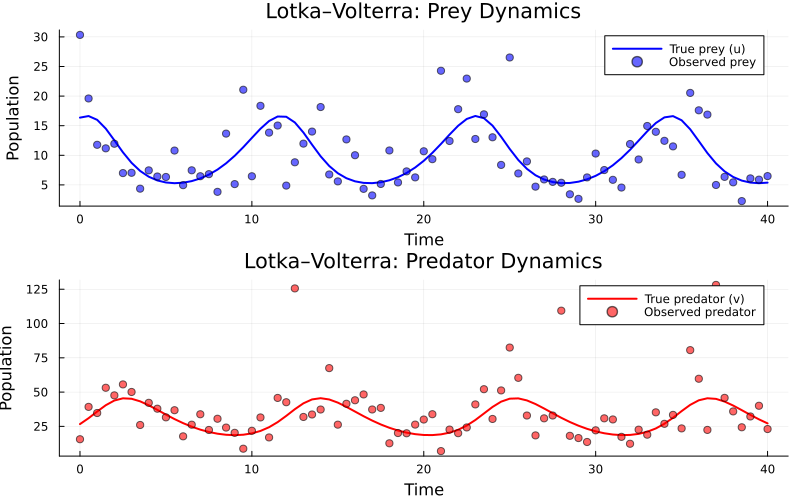

In [107]:
using Plots

# Plot the true trajectory and noisy observations
p1 = plot(ts, sim_result.z_true[:, 1], 
    label="True prey (u)", 
    linewidth=2, 
    color=:blue,
    xlabel="Time",
    ylabel="Population",
    title="Lotka–Volterra: Prey Dynamics")
scatter!(p1, ts, sim_result.y_obs[:, 1], 
    label="Observed prey", 
    color=:blue, 
    alpha=0.6,
    markersize=4)

p2 = plot(ts, sim_result.z_true[:, 2], 
    label="True predator (v)", 
    linewidth=2, 
    color=:red,
    xlabel="Time",
    ylabel="Population",
    title="Lotka–Volterra: Predator Dynamics")
scatter!(p2, ts, sim_result.y_obs[:, 2], 
    label="Observed predator", 
    color=:red, 
    alpha=0.6,
    markersize=4)

plot(p1, p2, layout=(2, 1), size=(800, 500), legend=:topright)


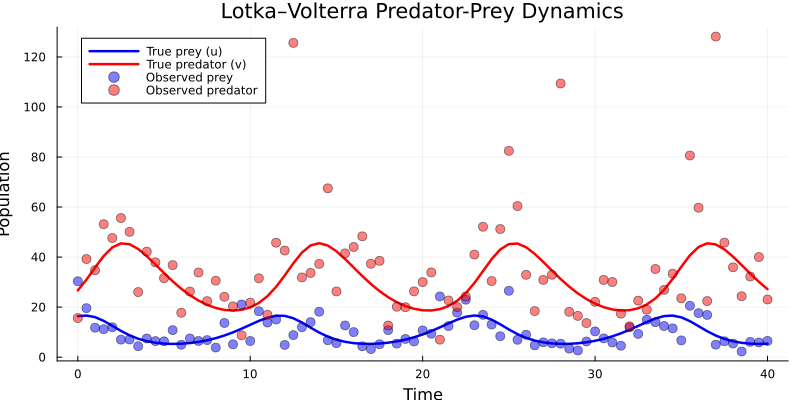

In [108]:
# Combined plot: both species together
plot(ts, sim_result.z_true[:, 1], 
    label="True prey (u)", 
    linewidth=2.5, 
    color=:blue,
    xlabel="Time",
    ylabel="Population",
    title="Lotka–Volterra Predator-Prey Dynamics",
    size=(800, 400))
plot!(ts, sim_result.z_true[:, 2], 
    label="True predator (v)", 
    linewidth=2.5, 
    color=:red)
scatter!(ts, sim_result.y_obs[:, 1], 
    label="Observed prey", 
    color=:blue, 
    alpha=0.5,
    markersize=5)
scatter!(ts, sim_result.y_obs[:, 2], 
    label="Observed predator", 
    color=:red, 
    alpha=0.5,
    markersize=5)

# Inference

## Importance Sampling

In [109]:
function make_y_constraints(y_obs)
    T, D = size(y_obs)
    constraints = Gen.choicemap()
    for t in 1:T
        for i in 1:D
            # In the model, the random choice is y_log ~ Normal(log(z_true), sigma_obs)
            # and y_obs = exp(y_log). So we must constrain y_log = log(y_obs).
            constraints[(:y, t, i)] = log(y_obs[t, i])
        end
    end
    return constraints
end

function infer_is(ts, y_obs; N=2_000)
    constraints = make_y_constraints(y_obs)

    # Use importance_sampling which returns (traces, log_normalized_weights, log_ml_estimate)
    traces, log_normalized_weights, log_ml_estimate = Gen.importance_sampling(lv_model, (ts,), constraints, N)
    
    # Return traces directly - they are already properly weighted samples from the posterior
    return traces, log_ml_estimate
end

function extract_params(trace)
    # Use Gen.get_choices to get the choicemap, then index into it
    choices = Gen.get_choices(trace)
    
    alpha = exp(choices[:alpha_log])
    beta  = exp(choices[:beta_log])
    gamma = exp(choices[:gamma_log])
    delta = exp(choices[:delta_log])
    z1 = exp(choices[(:z_init, 1)])
    z2 = exp(choices[(:z_init, 2)])
    sigma = exp(choices[:sigma_obs])
    return (alpha=alpha, beta=beta, gamma=gamma, delta=delta, z_init=(z1, z2), sigma_obs=sigma)
end

extract_params (generic function with 1 method)

In [110]:
# Run importance sampling inference
println("Running importance sampling with N=2000 particles...")
@time traces, log_ml_estimate = infer_is(ts, sim_result.y_obs, N=2000)

println("\nLog marginal likelihood estimate: $(round(log_ml_estimate, digits=2))")
println("Number of posterior samples: $(length(traces))")

Running importance sampling with N=2000 particles...
  0.482467 seconds (3.60 M allocations: 210.010 MiB, 17.34% gc time, 7.31% compilation time)

Log marginal likelihood estimate: -154.09
Number of posterior samples: 2000


In [111]:
# Extract parameters from all posterior samples
posterior_params = [extract_params(tr) for tr in traces]

# Compute posterior statistics
alphas = [p.alpha for p in posterior_params]
betas = [p.beta for p in posterior_params]
gammas = [p.gamma for p in posterior_params]
deltas = [p.delta for p in posterior_params]
sigmas = [p.sigma_obs for p in posterior_params]
z1s = [p.z_init[1] for p in posterior_params]
z2s = [p.z_init[2] for p in posterior_params]

println("Posterior parameter estimates (mean ± std):")
println("  α: $(round(mean(alphas), digits=4)) ± $(round(std(alphas), digits=4))  (true: $(round(sim_result.true_theta[1], digits=4)))")
println("  β: $(round(mean(betas), digits=4)) ± $(round(std(betas), digits=4))  (true: $(round(sim_result.true_theta[2], digits=4)))")
println("  γ: $(round(mean(gammas), digits=4)) ± $(round(std(gammas), digits=4))  (true: $(round(sim_result.true_theta[3], digits=4)))")
println("  δ: $(round(mean(deltas), digits=4)) ± $(round(std(deltas), digits=4))  (true: $(round(sim_result.true_theta[4], digits=4)))")
println("  σ_obs: $(round(mean(sigmas), digits=4)) ± $(round(std(sigmas), digits=4))  (true: $(round(sim_result.true_sigma_obs, digits=4)))")
println("  u₀: $(round(mean(z1s), digits=4)) ± $(round(std(z1s), digits=4))  (true: $(round(sim_result.true_z_init[1], digits=4)))")
println("  v₀: $(round(mean(z2s), digits=4)) ± $(round(std(z2s), digits=4))  (true: $(round(sim_result.true_z_init[2], digits=4)))")

Posterior parameter estimates (mean ± std):
  α: 1.1297 ± 0.6051  (true: 0.7241)
  β: 0.0576 ± 0.0315  (true: 0.0241)
  γ: 1.1241 ± 0.6345  (true: 0.4441)
  δ: 0.0569 ± 0.0298  (true: 0.0448)
  σ_obs: 0.6306 ± 0.8158  (true: 0.3985)
  u₀: 15.9854 ± 22.2115  (true: 16.3599)
  v₀: 17.123 ± 22.6685  (true: 26.6707)


## Posterior Predictive Visualization

Generate predicted trajectories from posterior samples and compare with observed data.

In [112]:
# Generate posterior predictive trajectories
posterior_params = [extract_params(tr) for tr in traces]

Random.seed!(12345)
n_samples = min(100, length(traces))  # Use subset for visualization
sample_indices = rand(1:length(traces), n_samples)

# Solve ODE for each posterior sample
predicted_trajectories = []
for idx in sample_indices
    params = posterior_params[idx]
    theta = (params.alpha, params.beta, params.gamma, params.delta)
    z_init = [params.z_init[1], params.z_init[2]]
    
    try
        z_pred = solve_lv(theta, z_init, ts)
        push!(predicted_trajectories, z_pred)
    catch
        # Skip samples that cause ODE solver issues
        continue
    end
end

println("Generated $(length(predicted_trajectories)) posterior predictive trajectories")

Generated 100 posterior predictive trajectories


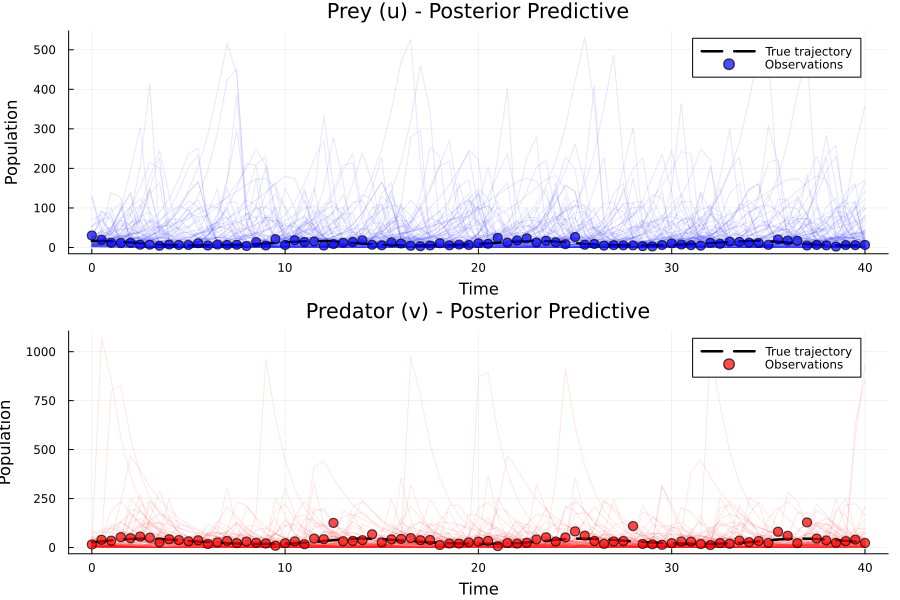

In [113]:
# Plot posterior predictive trajectories vs observed data
p1 = plot(title="Prey (u) - Posterior Predictive", xlabel="Time", ylabel="Population", legend=:topright)

# Plot posterior samples (light lines)
for z_pred in predicted_trajectories
    plot!(p1, ts, z_pred[:, 1], color=:blue, alpha=0.1, label="")
end

# Plot true trajectory and observations
plot!(p1, ts, sim_result.z_true[:, 1], color=:black, linewidth=2.5, label="True trajectory", linestyle=:dash)
scatter!(p1, ts, sim_result.y_obs[:, 1], color=:blue, markersize=5, alpha=0.7, label="Observations")

# Predator plot
p2 = plot(title="Predator (v) - Posterior Predictive", xlabel="Time", ylabel="Population", legend=:topright)

for z_pred in predicted_trajectories
    plot!(p2, ts, z_pred[:, 2], color=:red, alpha=0.1, label="")
end

plot!(p2, ts, sim_result.z_true[:, 2], color=:black, linewidth=2.5, label="True trajectory", linestyle=:dash)
scatter!(p2, ts, sim_result.y_obs[:, 2], color=:red, markersize=5, alpha=0.7, label="Observations")

plot(p1, p2, layout=(2, 1), size=(900, 600))

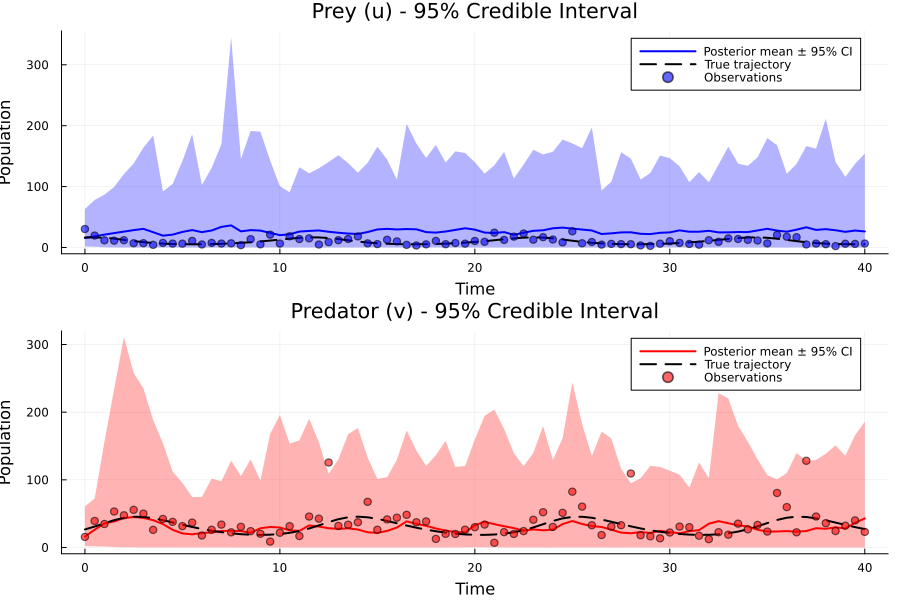

In [153]:
# Compute posterior predictive mean and credible intervals
n_traj = length(predicted_trajectories)
T = length(ts)

# Stack trajectories into arrays
prey_pred = zeros(n_traj, T)
pred_pred = zeros(n_traj, T)

for (i, z_pred) in enumerate(predicted_trajectories)
    prey_pred[i, :] = z_pred[:, 1]
    pred_pred[i, :] = z_pred[:, 2]
end

# Compute quantiles for credible intervals
prey_mean = vec(mean(prey_pred, dims=1))
prey_lower = vec(mapslices(x -> quantile(x, 0.025), prey_pred, dims=1))
prey_upper = vec(mapslices(x -> quantile(x, 0.975), prey_pred, dims=1))

pred_mean = vec(mean(pred_pred, dims=1))
pred_lower = vec(mapslices(x -> quantile(x, 0.025), pred_pred, dims=1))
pred_upper = vec(mapslices(x -> quantile(x, 0.975), pred_pred, dims=1))

# Plot with credible intervals
p1 = plot(title="Prey (u) - 95% Credible Interval", xlabel="Time", ylabel="Population")
plot!(p1, ts, prey_mean, ribbon=(prey_mean .- prey_lower, prey_upper .- prey_mean), 
      fillalpha=0.3, color=:blue, linewidth=2, label="Posterior mean ± 95% CI")
plot!(p1, ts, sim_result.z_true[:, 1], color=:black, linewidth=2, linestyle=:dash, label="True trajectory")
scatter!(p1, ts, sim_result.y_obs[:, 1], color=:blue, markersize=4, alpha=0.6, label="Observations")

p2 = plot(title="Predator (v) - 95% Credible Interval", xlabel="Time", ylabel="Population")
plot!(p2, ts, pred_mean, ribbon=(pred_mean .- pred_lower, pred_upper .- pred_mean), 
      fillalpha=0.3, color=:red, linewidth=2, label="Posterior mean ± 95% CI")
plot!(p2, ts, sim_result.z_true[:, 2], color=:black, linewidth=2, linestyle=:dash, label="True trajectory")
scatter!(p2, ts, sim_result.y_obs[:, 2], color=:red, markersize=4, alpha=0.6, label="Observations")

plot(p1, p2, layout=(2, 1), size=(900, 600), legend=:topright)

In [115]:
println("length(traces) = ", length(traces))
println("length(posterior_params) = ", length(posterior_params))

length(traces) = 2000
length(posterior_params) = 2000


## Metropolis-Hastings MCMC

MCMC is better suited for high-dimensional posteriors where importance sampling suffers from weight degeneracy.

In [116]:

function infer_mh_minimal(ts, y_obs; n_samples=2000)
    constraints = make_y_constraints(y_obs)
    
    # Initialize trace from the prior constrained to observations
    trace, _ = Gen.generate(lv_model, (ts,), constraints)
    
    println("Starting MCMC with $(n_samples) samples...")
    
    traces = []
    
    # MCMC iterations
    for i in 1:(n_samples)
        # Single MH update for all latent variables at once
        trace, _ = Gen.mh(trace, Gen.select(:alpha_log, :beta_log, :gamma_log, :delta_log, 
                                            (:z_init, 1), (:z_init, 2), :sigma_obs))
        
        # Collect samples after burn-in
        push!(traces, trace)
    end
    
    return traces
end

infer_mh_minimal (generic function with 1 method)

In [117]:
# Run Metropolis-Hastings inference
println("Running Metropolis-Hastings MCMC...")
@time traces_mh = infer_mh_minimal(ts, sim_result.y_obs, n_samples=2000)

println("\nNumber of posterior samples (MCMC): $(length(traces_mh))")

Running Metropolis-Hastings MCMC...
Starting MCMC with 2000 samples...
  0.521885 seconds (5.33 M allocations: 247.552 MiB, 10.93% gc time, 5.86% compilation time)

Number of posterior samples (MCMC): 2000


In [118]:
# Extract parameters from MCMC posterior samples
posterior_params_mh = [extract_params(tr) for tr in traces_mh]

# Compute posterior statistics
alphas_mh = [p.alpha for p in posterior_params_mh]
betas_mh = [p.beta for p in posterior_params_mh]
gammas_mh = [p.gamma for p in posterior_params_mh]
deltas_mh = [p.delta for p in posterior_params_mh]
sigmas_mh = [p.sigma_obs for p in posterior_params_mh]
z1s_mh = [p.z_init[1] for p in posterior_params_mh]
z2s_mh = [p.z_init[2] for p in posterior_params_mh]

println("MCMC Posterior parameter estimates (mean ± std):")
println("  α: $(round(mean(alphas_mh), digits=4)) ± $(round(std(alphas_mh), digits=4))  (true: $(round(sim_result.true_theta[1], digits=4)))")
println("  β: $(round(mean(betas_mh), digits=4)) ± $(round(std(betas_mh), digits=4))  (true: $(round(sim_result.true_theta[2], digits=4)))")
println("  γ: $(round(mean(gammas_mh), digits=4)) ± $(round(std(gammas_mh), digits=4))  (true: $(round(sim_result.true_theta[3], digits=4)))")
println("  δ: $(round(mean(deltas_mh), digits=4)) ± $(round(std(deltas_mh), digits=4))  (true: $(round(sim_result.true_theta[4], digits=4)))")
println("  σ_obs: $(round(mean(sigmas_mh), digits=4)) ± $(round(std(sigmas_mh), digits=4))  (true: $(round(sim_result.true_sigma_obs, digits=4)))")
println("  u₀: $(round(mean(z1s_mh), digits=4)) ± $(round(std(z1s_mh), digits=4))  (true: $(round(sim_result.true_z_init[1], digits=4)))")
println("  v₀: $(round(mean(z2s_mh), digits=4)) ± $(round(std(z2s_mh), digits=4))  (true: $(round(sim_result.true_z_init[2], digits=4)))")

MCMC Posterior parameter estimates (mean ± std):
  α: 0.8316 ± 0.2144  (true: 0.7241)
  β: 0.024 ± 0.0063  (true: 0.0241)
  γ: 0.5338 ± 0.0531  (true: 0.4441)
  δ: 0.0452 ± 0.0043  (true: 0.0448)
  σ_obs: 0.647 ± 0.129  (true: 0.3985)
  u₀: 15.9176 ± 3.6328  (true: 16.3599)
  v₀: 19.9783 ± 6.5862  (true: 26.6707)


### MCMC Trace Plots

Visualize the MCMC chains to check for convergence and mixing.

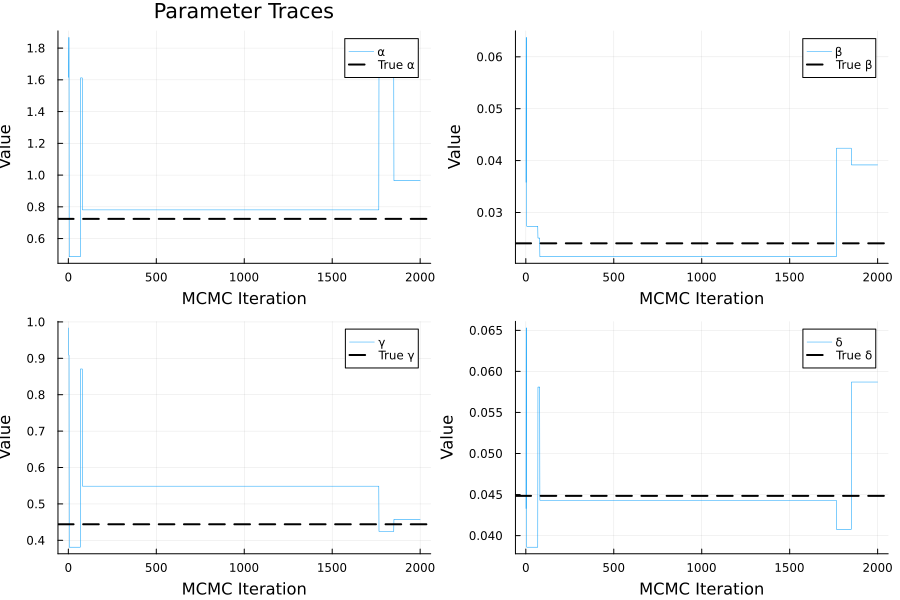

In [119]:
# Trace plots for MCMC diagnostics
p1 = plot(alphas_mh, label="α", xlabel="MCMC Iteration", ylabel="Value", title="Parameter Traces", linewidth=0.5)
hline!(p1, [sim_result.true_theta[1]], label="True α", linestyle=:dash, color=:black, linewidth=2)

p2 = plot(betas_mh, label="β", xlabel="MCMC Iteration", ylabel="Value", linewidth=0.5)
hline!(p2, [sim_result.true_theta[2]], label="True β", linestyle=:dash, color=:black, linewidth=2)

p3 = plot(gammas_mh, label="γ", xlabel="MCMC Iteration", ylabel="Value", linewidth=0.5)
hline!(p3, [sim_result.true_theta[3]], label="True γ", linestyle=:dash, color=:black, linewidth=2)

p4 = plot(deltas_mh, label="δ", xlabel="MCMC Iteration", ylabel="Value", linewidth=0.5)
hline!(p4, [sim_result.true_theta[4]], label="True δ", linestyle=:dash, color=:black, linewidth=2)

plot(p1, p2, p3, p4, layout=(2, 2), size=(900, 600), legend=:topright)

### MCMC Posterior Predictive Visualization

In [120]:
# Generate posterior predictive trajectories from MCMC samples
Random.seed!(12345)
n_samples_viz = min(100, length(traces_mh))
sample_indices_mh = rand(1:length(traces_mh), n_samples_viz)

predicted_trajectories_mh = []
for idx in sample_indices_mh
    params = posterior_params_mh[idx]
    theta = (params.alpha, params.beta, params.gamma, params.delta)
    z_init = [params.z_init[1], params.z_init[2]]
    
    try
        z_pred = solve_lv(theta, z_init, ts)
        push!(predicted_trajectories_mh, z_pred)
    catch
        # Skip samples that cause ODE solver issues
        continue
    end
end

println("Generated $(length(predicted_trajectories_mh)) MCMC posterior predictive trajectories")

Generated 100 MCMC posterior predictive trajectories


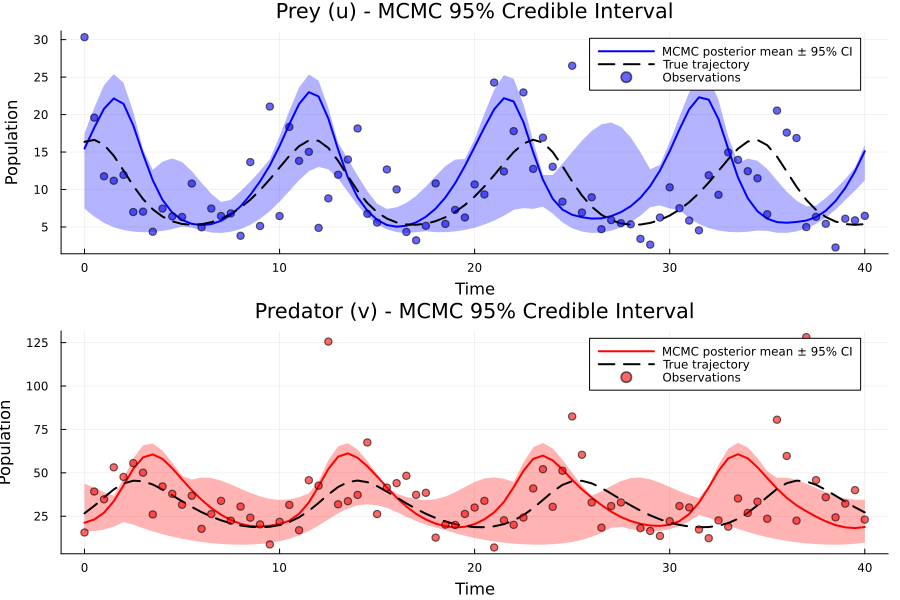

In [121]:
# Compute MCMC posterior predictive mean and credible intervals
n_traj_mh = length(predicted_trajectories_mh)
T = length(ts)

prey_pred_mh = zeros(n_traj_mh, T)
pred_pred_mh = zeros(n_traj_mh, T)

for (i, z_pred) in enumerate(predicted_trajectories_mh)
    prey_pred_mh[i, :] = z_pred[:, 1]
    pred_pred_mh[i, :] = z_pred[:, 2]
end

prey_mean_mh = vec(mean(prey_pred_mh, dims=1))
prey_lower_mh = vec(mapslices(x -> quantile(x, 0.025), prey_pred_mh, dims=1))
prey_upper_mh = vec(mapslices(x -> quantile(x, 0.975), prey_pred_mh, dims=1))

pred_mean_mh = vec(mean(pred_pred_mh, dims=1))
pred_lower_mh = vec(mapslices(x -> quantile(x, 0.025), pred_pred_mh, dims=1))
pred_upper_mh = vec(mapslices(x -> quantile(x, 0.975), pred_pred_mh, dims=1))

# Plot MCMC results
p1 = plot(title="Prey (u) - MCMC 95% Credible Interval", xlabel="Time", ylabel="Population")
plot!(p1, ts, prey_mean_mh, ribbon=(prey_mean_mh .- prey_lower_mh, prey_upper_mh .- prey_mean_mh), 
      fillalpha=0.3, color=:blue, linewidth=2, label="MCMC posterior mean ± 95% CI")
plot!(p1, ts, sim_result.z_true[:, 1], color=:black, linewidth=2, linestyle=:dash, label="True trajectory")
scatter!(p1, ts, sim_result.y_obs[:, 1], color=:blue, markersize=4, alpha=0.6, label="Observations")

p2 = plot(title="Predator (v) - MCMC 95% Credible Interval", xlabel="Time", ylabel="Population")
plot!(p2, ts, pred_mean_mh, ribbon=(pred_mean_mh .- pred_lower_mh, pred_upper_mh .- pred_mean_mh), 
      fillalpha=0.3, color=:red, linewidth=2, label="MCMC posterior mean ± 95% CI")
plot!(p2, ts, sim_result.z_true[:, 2], color=:black, linewidth=2, linestyle=:dash, label="True trajectory")
scatter!(p2, ts, sim_result.y_obs[:, 2], color=:red, markersize=4, alpha=0.6, label="Observations")

plot(p1, p2, layout=(2, 1), size=(900, 600), legend=:topright)

### Comparison: Importance Sampling vs MCMC

Compare the posterior estimates from both inference methods.

In [144]:

println("PARAMETER CORRELATION ANALYSIS")

# MCMC correlations
param_matrix_mh = hcat(alphas_mh, betas_mh, gammas_mh, deltas_mh)
cor_matrix_mh = cor(param_matrix_mh)

println("\n Metropolis Hastings MCMC Parameter Correlations:")
println("        α      β      γ      δ")
for (i, name) in enumerate(["α", "β", "γ", "δ"])
    print(rpad(name, 8))
    for j in 1:4
        print(rpad(round(cor_matrix_mh[i,j], digits=3), 7))
    end
    println()
end

# IS correlations
param_matrix_is = hcat(alphas, betas, gammas, deltas)
cor_matrix_is = cor(param_matrix_is)

println("\nIS Parameter Correlations:")
println("        α      β      γ      δ")
for (i, name) in enumerate(["α", "β", "γ", "δ"])
    print(rpad(name, 8))
    for j in 1:4
        print(rpad(round(cor_matrix_is[i,j], digits=3), 7))
    end
    println()
end



PARAMETER CORRELATION ANALYSIS

 Metropolis Hastings MCMC Parameter Correlations:
        α      β      γ      δ
α       1.0    0.729  -0.143 0.181  
β       0.729  1.0    -0.578 0.534  
γ       -0.143 -0.578 1.0    -0.003 
δ       0.181  0.534  -0.003 1.0    

IS Parameter Correlations:
        α      β      γ      δ
α       1.0    0.017  0.004  0.005  
β       0.017  1.0    -0.007 -0.007 
γ       0.004  -0.007 1.0    -0.018 
δ       0.005  -0.007 -0.018 1.0    



# Custom Inference

In [145]:
# Custom random-walk proposal in log-space
@gen function random_walk_proposal(trace, addr, step_size)
    current_val = trace[addr]
    {addr} ~ Gen.normal(current_val, step_size)
end

# Block proposal for two addresses (e.g., alpha_log and beta_log)
@gen function block_proposal_2(trace, addr1, addr2, step1, step2)
    current1 = trace[addr1]
    current2 = trace[addr2]
    {addr1} ~ Gen.normal(current1, step1)
    {addr2} ~ Gen.normal(current2, step2)
end

# Block proposal for initial conditions
@gen function init_proposal(trace, step_u0, step_v0)
    current_u0 = trace[(:z_init, 1)]
    current_v0 = trace[(:z_init, 2)]
    {(:z_init, 1)} ~ Gen.normal(current_u0, step_u0)
    {(:z_init, 2)} ~ Gen.normal(current_v0, step_v0)
end

function infer_mh_blocked(ts, y_obs; 
                          n_burnin=1000, 
                          n_samples=2000, 
                          thin=5,
                          step_alpha=0.1, step_beta=0.1,
                          step_gamma=0.1, step_delta=0.1,
                          step_u0=0.1, step_v0=0.1,
                          step_sigma=0.1,
                          adapt=true)
    
    constraints = make_y_constraints(y_obs)
    trace, _ = Gen.generate(lv_model, (ts,), constraints)
    
    # Updated tracking: separate gamma and delta since they're uncorrelated
    accepts = Dict(:alpha_beta => 0, :gamma => 0, :delta => 0, :init_block => 0, :sigma => 0)
    total = Dict(:alpha_beta => 0, :gamma => 0, :delta => 0, :init_block => 0, :sigma => 0)
    
    steps = Dict(
        :alpha => step_alpha, :beta => step_beta,
        :gamma => step_gamma, :delta => step_delta,
        :u0 => step_u0, :v0 => step_v0,
        :sigma => step_sigma
    )
    
    println("Starting blocked MCMC (burnin=$(n_burnin), samples=$(n_samples), thin=$(thin))...")
    println("Initial step sizes: α=$(step_alpha), β=$(step_beta), γ=$(step_gamma), δ=$(step_delta)")
    println("\nBlocking strategy based on correlation analysis:")
    println("  • (α, β) block: correlation = 0.729 (strong positive)")
    println("  • γ separate: correlation with δ = -0.003 (independent)")
    println("  • δ separate: correlation with γ = -0.003 (independent)")
    println("  • (u₀, v₀) block: initial conditions")
    println("  • σ separate")
    
    adapt_interval = 50
    
    # ===== BURN-IN PHASE =====
    for i in 1:n_burnin
        # Block 1: α,β (strong correlation 0.729)
        trace, acc1 = Gen.mh(trace, block_proposal_2, (:alpha_log, :beta_log, steps[:alpha], steps[:beta]))
        
        # Separate updates for γ and δ (correlation -0.003, essentially independent)
        trace, acc2 = Gen.mh(trace, random_walk_proposal, (:gamma_log, steps[:gamma]))
        trace, acc3 = Gen.mh(trace, random_walk_proposal, (:delta_log, steps[:delta]))
        
        # Block: u₀,v₀ (initial conditions)
        trace, acc4 = Gen.mh(trace, init_proposal, (steps[:u0], steps[:v0]))
        
        # Single: σ
        trace, acc5 = Gen.mh(trace, random_walk_proposal, (:sigma_obs, steps[:sigma]))
        
        accepts[:alpha_beta] += acc1; total[:alpha_beta] += 1
        accepts[:gamma] += acc2; total[:gamma] += 1
        accepts[:delta] += acc3; total[:delta] += 1
        accepts[:init_block] += acc4; total[:init_block] += 1
        accepts[:sigma] += acc5; total[:sigma] += 1
        
        # Adaptive step size tuning during burn-in
        if adapt && i % adapt_interval == 0
            for (block, step_keys) in [
                (:alpha_beta, [:alpha, :beta]),
                (:gamma, [:gamma]),
                (:delta, [:delta]),
                (:init_block, [:u0, :v0]),
                (:sigma, [:sigma])
            ]
                rate = accepts[block] / total[block]
                if rate < 0.15
                    for k in step_keys; steps[k] *= 0.8; end
                elseif rate > 0.40
                    for k in step_keys; steps[k] *= 1.2; end
                end
            end
            # Reset counters after adaptation
            for k in keys(accepts); accepts[k] = 0; total[k] = 0; end
        end
    end
    
    println("\nAdapted step sizes: α=$(round(steps[:alpha], digits=4)), β=$(round(steps[:beta], digits=4)), " *
            "γ=$(round(steps[:gamma], digits=4)), δ=$(round(steps[:delta], digits=4))")
    
    # Reset counters for sampling phase
    for k in keys(accepts); accepts[k] = 0; total[k] = 0; end
    
    # sampling 
    println("\nSampling phase ($(n_samples * thin) iterations, keeping every $(thin)th)...")
    traces = []
    
    for i in 1:(n_samples * thin)
        # Block 1: α,β (strong correlation 0.729)
        trace, acc1 = Gen.mh(trace, block_proposal_2, (:alpha_log, :beta_log, steps[:alpha], steps[:beta]))
        
        # Separate updates for γ and δ (correlation -0.003, essentially independent)
        trace, acc2 = Gen.mh(trace, random_walk_proposal, (:gamma_log, steps[:gamma]))
        trace, acc3 = Gen.mh(trace, random_walk_proposal, (:delta_log, steps[:delta]))
        
        # Block: u₀,v₀ (initial conditions)
        trace, acc4 = Gen.mh(trace, init_proposal, (steps[:u0], steps[:v0]))
        
        # Single: σ
        trace, acc5 = Gen.mh(trace, random_walk_proposal, (:sigma_obs, steps[:sigma]))
        
        accepts[:alpha_beta] += acc1; total[:alpha_beta] += 1
        accepts[:gamma] += acc2; total[:gamma] += 1
        accepts[:delta] += acc3; total[:delta] += 1
        accepts[:init_block] += acc4; total[:init_block] += 1
        accepts[:sigma] += acc5; total[:sigma] += 1
        
        if i % thin == 0
            push!(traces, trace)
        end
    end
    
    # Print acceptance rates
    println("ACCEPTANCE RATES (Sampling Phase)")
    for (block, name) in [(:alpha_beta, "α,β block"), (:gamma, "γ"), (:delta, "δ"),
                          (:init_block, "u₀,v₀ block"), (:sigma, "σ")]
        rate = 100 * accepts[block] / total[block]
        status = rate < 10 ? "acc rate too low" : (rate > 50 ? "acc rate too high" : " ok")
        println("  $(rpad(name, 12)): $(round(rate, digits=1))%  $(status)")
    end
    println("="^60)
    
    return traces
end

infer_mh_blocked (generic function with 1 method)

In [146]:
println("Running blocked MH with correlation-informed blocking...")
@time traces_blocked = infer_mh_blocked(ts, sim_result.y_obs, 
                                         n_burnin=2000, 
                                         n_samples=2000, 
                                         thin=5,
                                         step_alpha=0.15, step_beta=0.15,
                                         step_gamma=0.15, step_delta=0.15,
                                         step_u0=0.2, step_v0=0.2,
                                         step_sigma=0.2,
                                         adapt=true)

println("\nNumber of posterior samples: $(length(traces_blocked))")

# Extract and analyze
posterior_params_blocked = [extract_params(tr) for tr in traces_blocked]
alphas_blocked = [p.alpha for p in posterior_params_blocked]
betas_blocked = [p.beta for p in posterior_params_blocked]
gammas_blocked = [p.gamma for p in posterior_params_blocked]
deltas_blocked = [p.delta for p in posterior_params_blocked]
sigmas_blocked = [p.sigma_obs for p in posterior_params_blocked]
z1s_blocked = [p.z_init[1] for p in posterior_params_blocked]
z2s_blocked = [p.z_init[2] for p in posterior_params_blocked]

println("\nBlocked MH Posterior estimates:")
println("  α: $(round(mean(alphas_blocked), digits=4)) ± $(round(std(alphas_blocked), digits=4))  (true: $(round(sim_result.true_theta[1], digits=4)))")
println("  β: $(round(mean(betas_blocked), digits=4)) ± $(round(std(betas_blocked), digits=4))  (true: $(round(sim_result.true_theta[2], digits=4)))")
println("  γ: $(round(mean(gammas_blocked), digits=4)) ± $(round(std(gammas_blocked), digits=4))  (true: $(round(sim_result.true_theta[3], digits=4)))")
println("  δ: $(round(mean(deltas_blocked), digits=4)) ± $(round(std(deltas_blocked), digits=4))  (true: $(round(sim_result.true_theta[4], digits=4)))")
println("  σ: $(round(mean(sigmas_blocked), digits=4)) ± $(round(std(sigmas_blocked), digits=4))  (true: $(round(sim_result.true_sigma_obs, digits=4)))")
println("  u₀: $(round(mean(z1s_blocked), digits=4)) ± $(round(std(z1s_blocked), digits=4))  (true: $(round(sim_result.true_z_init[1], digits=4)))")
println("  v₀: $(round(mean(z2s_blocked), digits=4)) ± $(round(std(z2s_blocked), digits=4))  (true: $(round(sim_result.true_z_init[2], digits=4)))")

Running blocked MH with correlation-informed blocking...
Starting blocked MCMC (burnin=2000, samples=2000, thin=5)...
Initial step sizes: α=0.15, β=0.15, γ=0.15, δ=0.15

Blocking strategy based on correlation analysis:
  • (α, β) block: correlation = 0.729 (strong positive)
  • γ separate: correlation with δ = -0.003 (independent)
  • δ separate: correlation with γ = -0.003 (independent)
  • (u₀, v₀) block: initial conditions
  • σ separate

Adapted step sizes: α=0.0472, β=0.0472, γ=0.0453, δ=0.1327Starting blocked MCMC (burnin=2000, samples=2000, thin=5)...
Initial step sizes: α=0.15, β=0.15, γ=0.15, δ=0.15

Blocking strategy based on correlation analysis:
  • (α, β) block: correlation = 0.729 (strong positive)
  • γ separate: correlation with δ = -0.003 (independent)
  • δ separate: correlation with γ = -0.003 (independent)
  • (u₀, v₀) block: initial conditions
  • σ separate

Adapted step sizes: α=0.0472, β=0.0472, γ=0.0453, δ=0.1327

Sampling phase (10000 iterations, keeping every

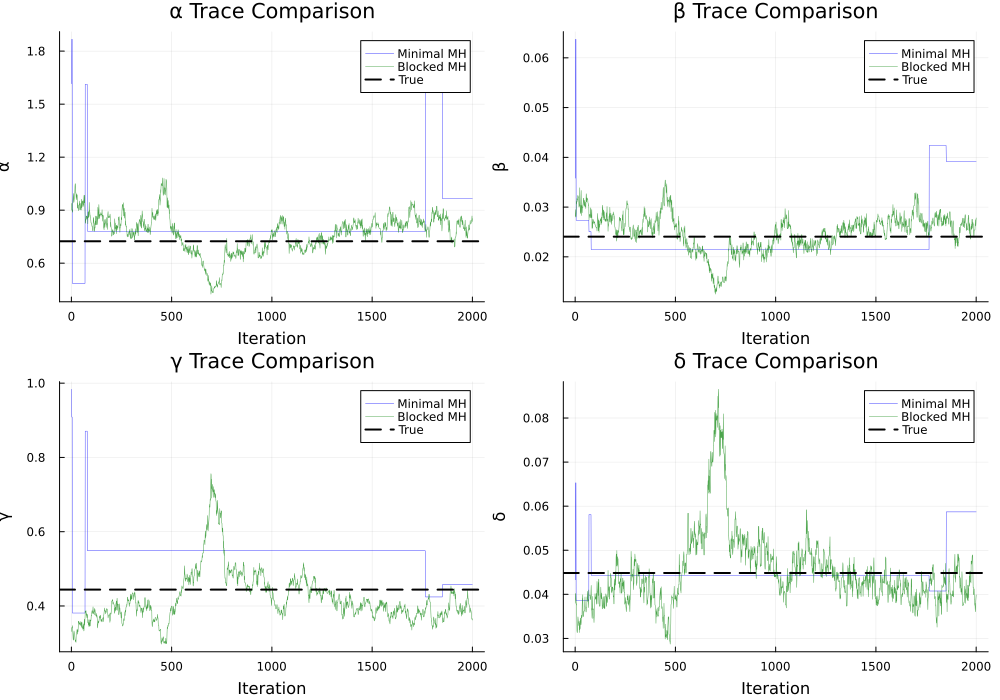

In [147]:
# Side-by-side trace plots comparison (Minimal vs Improved vs Blocked)
p1 = plot(alphas_mh, label="Minimal MH", xlabel="Iteration", ylabel="α", 
          title="α Trace Comparison", linewidth=0.5, color=:blue, alpha=0.7)
plot!(p1, alphas_blocked, label="Blocked MH", linewidth=0.5, color=:green, alpha=0.7)
hline!(p1, [sim_result.true_theta[1]], label="True", linestyle=:dash, color=:black, linewidth=2)

p2 = plot(betas_mh, label="Minimal MH", xlabel="Iteration", ylabel="β", 
          title="β Trace Comparison", linewidth=0.5, color=:blue, alpha=0.7)
plot!(p2, betas_blocked, label="Blocked MH", linewidth=0.5, color=:green, alpha=0.7)
hline!(p2, [sim_result.true_theta[2]], label="True", linestyle=:dash, color=:black, linewidth=2)

p3 = plot(gammas_mh, label="Minimal MH", xlabel="Iteration", ylabel="γ", 
          title="γ Trace Comparison", linewidth=0.5, color=:blue, alpha=0.7)
plot!(p3, gammas_blocked, label="Blocked MH", linewidth=0.5, color=:green, alpha=0.7)
hline!(p3, [sim_result.true_theta[3]], label="True", linestyle=:dash, color=:black, linewidth=2)

p4 = plot(deltas_mh, label="Minimal MH", xlabel="Iteration", ylabel="δ", 
          title="δ Trace Comparison", linewidth=0.5, color=:blue, alpha=0.7)
plot!(p4, deltas_blocked, label="Blocked MH", linewidth=0.5, color=:green, alpha=0.7)
hline!(p4, [sim_result.true_theta[4]], label="True", linestyle=:dash, color=:black, linewidth=2)

plot(p1, p2, p3, p4, layout=(2, 2), size=(1000, 700), legend=:topright)

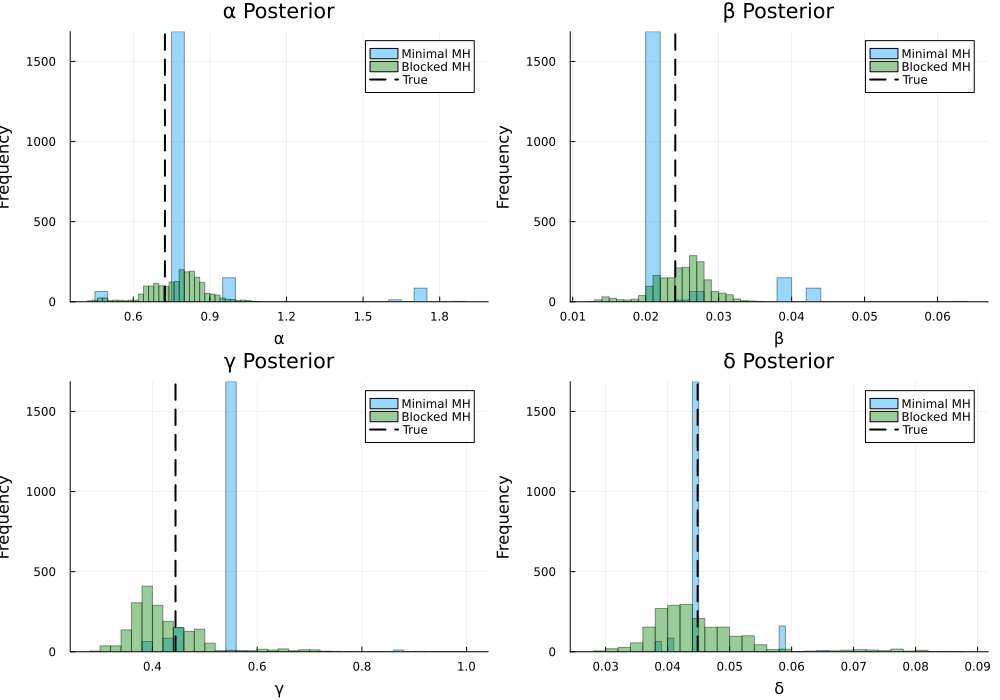

In [148]:
# Posterior histogram comparison (Minimal vs Improved vs Blocked)
p1 = histogram(alphas_mh, label="Minimal MH", alpha=0.4, bins=30, xlabel="α", ylabel="Frequency", title="α Posterior")
histogram!(p1, alphas_blocked, label="Blocked MH", alpha=0.4, bins=30, color=:green)
vline!(p1, [sim_result.true_theta[1]], label="True", linewidth=2, color=:black, linestyle=:dash)

p2 = histogram(betas_mh, label="Minimal MH", alpha=0.4, bins=30, xlabel="β", ylabel="Frequency", title="β Posterior")
histogram!(p2, betas_blocked, label="Blocked MH", alpha=0.4, bins=30, color=:green)
vline!(p2, [sim_result.true_theta[2]], label="True", linewidth=2, color=:black, linestyle=:dash)

p3 = histogram(gammas_mh, label="Minimal MH", alpha=0.4, bins=30, xlabel="γ", ylabel="Frequency", title="γ Posterior")
histogram!(p3, gammas_blocked, label="Blocked MH", alpha=0.4, bins=30, color=:green)
vline!(p3, [sim_result.true_theta[3]], label="True", linewidth=2, color=:black, linestyle=:dash)

p4 = histogram(deltas_mh, label="Minimal MH", alpha=0.4, bins=30, xlabel="δ", ylabel="Frequency", title="δ Posterior")
histogram!(p4, deltas_blocked, label="Blocked MH", alpha=0.4, bins=30, color=:green)
vline!(p4, [sim_result.true_theta[4]], label="True", linewidth=2, color=:black, linestyle=:dash)

plot(p1, p2, p3, p4, layout=(2, 2), size=(1000, 700), legend=:topright)

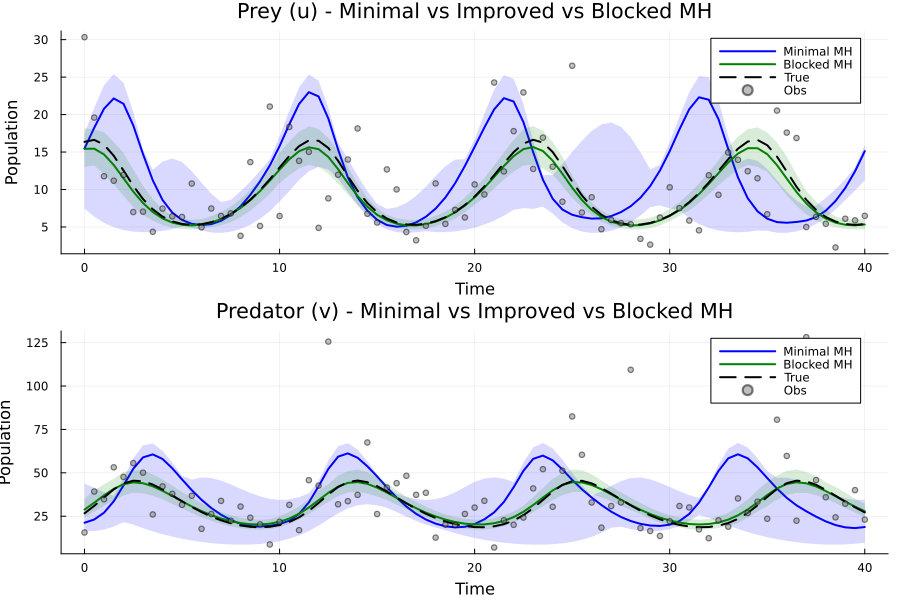

In [154]:
# Posterior predictive comparison (Minimal vs Improved vs Blocked)
Random.seed!(12345)



# Generate trajectories for blocked MH
sample_indices_blocked = rand(1:length(traces_blocked), n_samples_viz)
predicted_trajectories_blocked = []
for idx in sample_indices_blocked
    params = posterior_params_blocked[idx]
    theta = (params.alpha, params.beta, params.gamma, params.delta)
    z_init = [params.z_init[1], params.z_init[2]]
    try
        z_pred = solve_lv(theta, z_init, ts)
        push!(predicted_trajectories_blocked, z_pred)
    catch; continue; end
end


# Compute credible intervals for blocked MH
n_traj_blocked = length(predicted_trajectories_blocked)
prey_pred_blocked = zeros(n_traj_blocked, length(ts))
pred_pred_blocked = zeros(n_traj_blocked, length(ts))
for (i, z_pred) in enumerate(predicted_trajectories_blocked)
    prey_pred_blocked[i, :] = z_pred[:, 1]
    pred_pred_blocked[i, :] = z_pred[:, 2]
end
prey_mean_blocked = vec(mean(prey_pred_blocked, dims=1))
prey_lower_blocked = vec(mapslices(x -> quantile(x, 0.025), prey_pred_blocked, dims=1))
prey_upper_blocked = vec(mapslices(x -> quantile(x, 0.975), prey_pred_blocked, dims=1))
pred_mean_blocked = vec(mean(pred_pred_blocked, dims=1))
pred_lower_blocked = vec(mapslices(x -> quantile(x, 0.025), pred_pred_blocked, dims=1))
pred_upper_blocked = vec(mapslices(x -> quantile(x, 0.975), pred_pred_blocked, dims=1))

# Plot comparison
p1 = plot(title="Prey (u) - Minimal vs Improved vs Blocked MH", xlabel="Time", ylabel="Population")
plot!(p1, ts, prey_mean_mh, ribbon=(prey_mean_mh .- prey_lower_mh, prey_upper_mh .- prey_mean_mh), 
      fillalpha=0.15, color=:blue, linewidth=2, label="Minimal MH")
plot!(p1, ts, prey_mean_blocked, ribbon=(prey_mean_blocked .- prey_lower_blocked, prey_upper_blocked .- prey_mean_blocked), 
      fillalpha=0.15, color=:green, linewidth=2, label="Blocked MH")
plot!(p1, ts, sim_result.z_true[:, 1], color=:black, linewidth=2, linestyle=:dash, label="True")
scatter!(p1, ts, sim_result.y_obs[:, 1], color=:gray, markersize=3, alpha=0.5, label="Obs")

p2 = plot(title="Predator (v) - Minimal vs Improved vs Blocked MH", xlabel="Time", ylabel="Population")
plot!(p2, ts, pred_mean_mh, ribbon=(pred_mean_mh .- pred_lower_mh, pred_upper_mh .- pred_mean_mh), 
      fillalpha=0.15, color=:blue, linewidth=2, label="Minimal MH")
plot!(p2, ts, pred_mean_blocked, ribbon=(pred_mean_blocked .- pred_lower_blocked, pred_upper_blocked .- pred_mean_blocked), 
      fillalpha=0.15, color=:green, linewidth=2, label="Blocked MH")
plot!(p2, ts, sim_result.z_true[:, 2], color=:black, linewidth=2, linestyle=:dash, label="True")
scatter!(p2, ts, sim_result.y_obs[:, 2], color=:gray, markersize=3, alpha=0.5, label="Obs")

plot(p1, p2, layout=(2, 1), size=(900, 600), legend=:topright)